In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
# Load Data
# Fetching stock data for a company (e.g., Apple Inc.)
data = yf.download('AAPL', start='2010-01-01', end='2023-01-01')
# Use the 'Close' price for prediction
data = data[['Close']]

[*********************100%***********************]  1 of 1 completed


In [3]:
#  Preprocess Data
# Scaling the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [4]:

# Split the data into train and test
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [5]:

#  ARIMA Model
# Fit an ARIMA model (with example parameters)
arima_model = ARIMA(train_data, order=(5, 1, 0))  # Example (p,d,q)
arima_fit = arima_model.fit()

In [6]:
# ARIMA predictions on the test set
arima_predictions = arima_fit.forecast(steps=len(test_data))

In [7]:
#  LSTM Model
# Prepare data for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [8]:

# Reshape data for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [31]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
# Train the LSTM Model
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.1538e-05
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.8803e-05
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.4320e-05
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.1829e-05
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.4659e-05
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.1499e-05
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.5154e-05
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.1358e-05
Epoch 9/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.5991e-05
Epoch 10/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.9669e-05
Epoch 11/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.1413e-05
Epoch 12/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.5138e-05
Epoch 13/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.5093e-05
Epoch 14/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.9105e-05
Epoch 15/20
80/80 ━━━━━━━━

In [33]:
# LSTM predictions
lstm_predictions = lstm_model.predict(X_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [34]:
#  Combine ARIMA and LSTM Predictions
# ARIMA predictions on the test set
arima_predictions_scaled = arima_predictions.reshape(-1, 1)

In [35]:

# Inverse transform the ARIMA and LSTM predictions
arima_predictions_unscaled = scaler.inverse_transform(arima_predictions_scaled)
lstm_predictions_unscaled = scaler.inverse_transform(lstm_predictions)

In [36]:
# Step 6: Evaluation
# Calculate MSE and R-squared for both models

# For ARIMA (no issue here, because ARIMA predictions and actual data are aligned)
mse_arima = mean_squared_error(test_data, arima_predictions_unscaled)
r2_arima = r2_score(test_data, arima_predictions_unscaled)

# For LSTM:
# LSTM predictions start from time_step index (e.g., 60th data point).
# So we need to slice the test data from the time_step-th index
# to align with the LSTM predictions.
mse_lstm = mean_squared_error(test_data[time_step:len(test_data) - 1], lstm_predictions_unscaled)
r2_lstm = r2_score(test_data[time_step:len(test_data) - 1], lstm_predictions_unscaled)

# Print the evaluation metrics for both models
print(f"ARIMA Model - MSE: {mse_arima}, R-squared: {r2_arima}")
print(f"LSTM Model - MSE: {mse_lstm}, R-squared: {r2_lstm}")

ARIMA Model - MSE: 5890.930668808932, R-squared: -362284.79503211466
LSTM Model - MSE: 18421.629801604784, R-squared: -1743046.9655397169


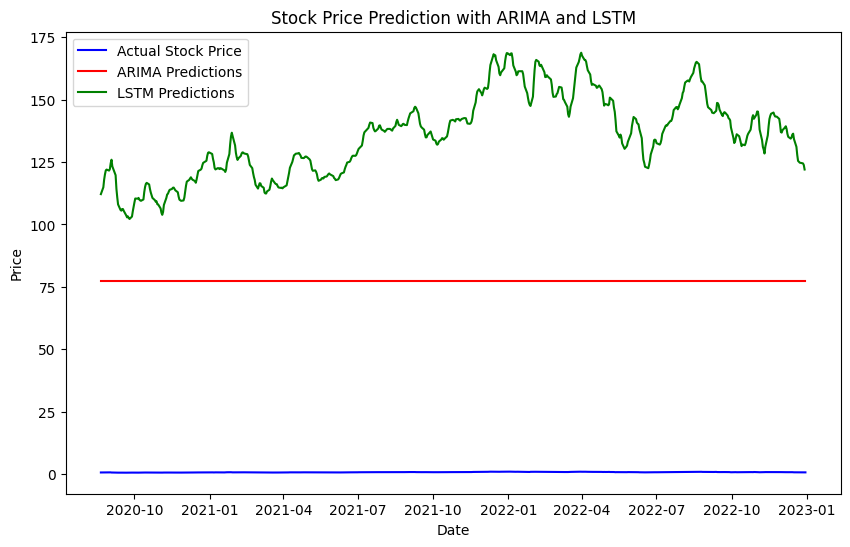

In [37]:
# Plot the Results
plt.figure(figsize=(10, 6))
plt.plot(data.index[train_size + time_step:], test_data[time_step:], color='blue', label='Actual Stock Price')
plt.plot(data.index[train_size + time_step:], arima_predictions_unscaled[time_step:], color='red', label='ARIMA Predictions')
plt.plot(data.index[train_size + time_step:len(data) - 1], lstm_predictions_unscaled, color='green', label='LSTM Predictions')  # Adjusted x-axis range
plt.title('Stock Price Prediction with ARIMA and LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()